In [1]:
import json
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
from sklearn.ensemble import RandomForestClassifier

In [2]:
def clean_lyrics(lyrics):
    if lyrics is None:
        return lyrics
    
    # combine lists of tokens into single string
    lyrics = ' '.join(lyrics)
            
    # remove apostrophes
    lyrics = lyrics.replace('\'', '')
            
    # remove song structure tags or instructions in brackets
    lyrics = re.sub(r'[\*\[|\(|\{].*\n*.*[\]\)\}\*]' , ' ', lyrics)
   
    # remove variations of Verse 1, VERSE 2, etc...
    for verse in ['verse', 'VERSE', 'Verse']:
        lyrics = re.sub(verse+' \d*', '', lyrics)
    
    # some structure markers formatted as allcaps without brackets
    for word in ['OUTRO', 'INSTRUMENTAL', 'PRE', 'HOOK',
                 'PRODUCED', 'REFRAIN', 'POST', 'REPEAT', '2x', '3x', '4x',
                 'CHORUS', 'INTRO', 'INTERLUDE']:
        lyrics = lyrics.replace(word, '')
        
    # remove varations of Chorus
    lyrics = re.sub(r'\n*Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'^Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'\nRepeat [C|c]horus:*.*' , ' ', lyrics)
    
    # remove variations of Intro
    lyrics = re.sub(r'Intro[\s|\n|:].*', ' ', lyrics)
    
    # remove variations of Instrumental
    lyrics = re.sub(r'-+.*[i|I]nstrumental.*-+', ' ', lyrics)
    lyrics = re.sub(r'\nBrief instrumental.*\n', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental break', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental--', ' ', lyrics)
    lyrics = re.sub(r'\n~Instrumental~', ' ', lyrics)
    
    # remove variations of Bridge
    lyrics = re.sub(r'\n\[*Bridge:\[*', ' ', lyrics)
    
    # remove variations of Hook
    lyrics = re.sub(r'Hook:.*', ' ', lyrics)
    
    # remove varations of Repeat
    lyrics = re.sub(r'Repeat\s.*', ' ', lyrics)
    lyrics = re.sub(r'\nRepeat$', ' ', lyrics)
    
    # remove credits
    lyrics = re.sub(r'.*[P|p]roduced [B|b]y.*', ' ', lyrics)
    lyrics = re.sub(r'.*[W|w]ritten [B|b]y.*', ' ', lyrics)
    
    # remove strays and typos
    lyrics = re.sub(r'\[Outro\[', ' ', lyrics)
    lyrics = re.sub(r'Sax & background & instrumental\)', ' ', lyrics)
    lyrics = re.sub(r'\nSource: ', ' ', lyrics)
    lyrics = re.sub(r'Shotgun 2: 58 Trk 1 \n  \nJr. Walker & The All Stars '\
                    +'\nAnd/or The Funk Brothers - instrumental \nPop Chart '\
                    +'#4 Feb 13, 1965 \nSoul Label - 35008   \n ', ' ', lyrics)
    lyrics = re.sub(r'- musical interlude -', ' ', lyrics)
    lyrics = re.sub(r'\nRefrain:', ' ', lyrics)
            
    # replace all punctuations with spaces
    lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
    # replace consecutive whitespaces with single space
    lyrics = re.sub(r'\s+', ' ', lyrics)
    
    # convert all tokens to lowercase
    lyrics = lyrics.lower()

    if lyrics[:29] == 'we do not have the lyrics for' or lyrics == 'instrumental':
        lyrics = None
    return lyrics


In [3]:
with open('../data/top_hits_lyrics.json') as json_file:
    top_hits_lyrics = json.load(json_file)

In [4]:
top_hits_lyrics[0]

{'id': '1rfofaqEpACxVEHIZBJe6W',
 'lyrics': ['[Intro: Pharrell Williams]',
  '\nHey',
  '\n',
  '\n[Chorus: Camila Cabello & ',
  'Pharrell Williams',
  ']',
  '\n',
  'Havana, ooh na-na (',
  'Ayy',
  ')',
  '\nHalf of my heart is in Havana, ooh na-na (',
  'Ayy, ayy',
  ')',
  '\n',
  'He took me back to East Atlanta, na-na-na, ah',
  '\n',
  'Oh, but my heart is in Havana (',
  'Ayy',
  ')',
  "\nThere's somethin' 'bout his manners (",
  'Uh-huh',
  ')',
  '\n',
  'Havana, ooh na-na (',
  'Uh',
  ')',
  '\n',
  '\n[Verse 1: Camila Cabello & ',
  'Pharrell Williams',
  ']',
  '\n',
  'He didn\'t walk up with that "how you doin\'?" (',
  'Uh',
  ')',
  '\nWhen he came in the room',
  "\nHe said there's a lot of girls I can do with (",
  'Uh',
  ')',
  "\nBut I can't without you",
  '\nI knew him forever in a minute (',
  'Hey',
  ')',
  '\nThat summer night in June',
  '\n',
  'And papa says he got malo in him (',
  'Uh',
  ')',
  "\nHe got me feelin' like...",
  '\n',
  '\n[Pre-Choru

In [5]:
top_hits_df = pd.DataFrame(top_hits_lyrics)
top_hits_df['clean_lyrics'] = top_hits_df['lyrics'].apply(lambda x: clean_lyrics(x))
top_hits_df = top_hits_df[top_hits_df['source'].notnull()]
top_hits_df = top_hits_df[top_hits_df['clean_lyrics'].notnull()]

In [6]:
top_hits_df.shape

(2805, 4)

In [7]:
with open('../data/songs_lyrics_5000.json') as json_file:
    not_hits_1 = json.load(json_file)

In [8]:
with open('../data/songs_lyrics_10000.json') as json_file:
    not_hits_2 = json.load(json_file)

In [9]:
not_hits_lyrics = not_hits_1 + not_hits_2

In [10]:
with open('../data/not_hits_lyrics.json', 'w') as f:
        json.dump(not_hits_lyrics, f)

In [11]:
not_hits_df = pd.DataFrame(not_hits_lyrics)
not_hits_df['clean_lyrics'] = not_hits_df['lyrics'].apply(lambda x: clean_lyrics(x))
not_hits_df = not_hits_df[not_hits_df['source'].notnull()]
not_hits_df = not_hits_df[not_hits_df['clean_lyrics'].notnull()]

In [12]:
not_hits_df.shape

(7937, 4)

In [13]:
# TODO: stratified sampling by decade
not_hits_df = not_hits_df.sample(n=top_hits_df.shape[0])

In [14]:
not_hits_df.shape

(2805, 4)

In [15]:
print(not_hits_df['clean_lyrics'].iloc[0])

yall ready for this get down with the style house on the ground please when i squeeze pump to your knees who wants to play im in here to stay ready to take you around the way so get ready for this mind your own biz cause i invented the microphone biz no need to sit cause were 2 unlimited ready ready ready for this feel the base you just get closer be impressed by the words i chose of once again kickin it live doin everything yo just to survive a wall to wall i think i stand being on stage with a mic in my hand bustin it live to the crowd the age is 20 im from the south be a part break my heart get ready for this mind your own biz people in the front show me what you want and i wont give it in get ready for this were 2 unlimited so people wont you sit movin up and down dancin on the ground feelin kinda free security house is style that moves you from the ground house on the ground bass in your face racin the place no time to waste feelin hypnotised i can see it in your eyes feelin kinda

In [16]:
top_hits_df['class'] = 1
not_hits_df['class'] = 0
df = pd.concat([top_hits_df, not_hits_df])

In [19]:
df.head()

,id,lyrics,source,clean_lyrics,class
0,1rfofaqEpACxVEHIZBJe6W,"[[Intro: Pharrell Williams], \nHey, \n, \n[Cho...",genius.com,hey half of my heart is in havana ooh na na h...,1
1,6rPO02ozF3bM7NnOV4h6s2,"[[Letra de ""Despacito"" ft. Daddy Yankee], \n, ...",genius.com,ay fonsi d y ohhh oh no oh no oh hey yeah did...,1
2,7mldq42yDuxiUNn08nvzHO,"[[Verse 1], \n, Got a girl from the south side...",genius.com,got a girl from the south side got braids in ...,1
3,1bhUWB0zJMIKr9yVPrkEuI,"[[Verse 1: Ed Sheeran], \n, I found a love for...",genius.com,i found a love for me oh darling just dive ri...,1
4,7iDa6hUg2VgEL1o1HjmfBn,"[[Verse 1: Florida Georgia Line], \nBaby, lay ...",genius.com,baby lay on back and relax kick your pretty f...,1


# Most redundant words

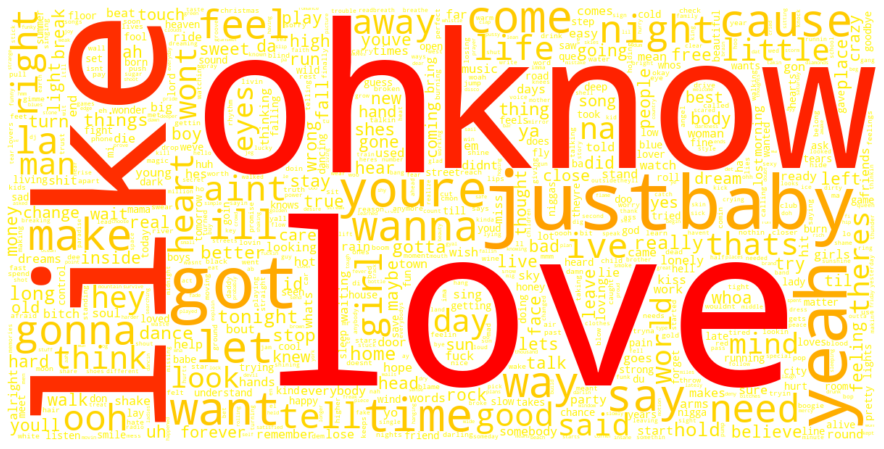

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
lyrics = df['clean_lyrics'].dropna().values.tolist()


# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)
    
# calculate word frequencies
stop_words = list(ENGLISH_STOP_WORDS) + ['im', 'dont']
count = CountVectorizer(stop_words=stop_words)
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count.get_feature_names(), freqs))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2, width=1200, color_func=colormap_size_func('autumn_r', 300), max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');


# Audio Features

In [29]:
with open('../data/top_hits.json') as json_file:
    top_hits = json.load(json_file)

In [30]:
top_hits_songs_df = pd.DataFrame(top_hits)

In [31]:
top_hits_merged_df = pd.merge(top_hits_df, top_hits_songs_df, on='id', how='inner')

In [32]:
top_hits_merged_df.shape

(2805, 37)

In [33]:
with open('../data/songs.json') as json_file:
    not_hits = json.load(json_file)

In [34]:
not_hits_songs_df = pd.DataFrame(not_hits)

In [35]:
not_hits_merged_df = pd.merge(not_hits_df, not_hits_songs_df, on='id', how='inner')

In [36]:
not_hits_merged_df.shape


(2805, 37)

In [ ]:
merged_df = pd.concat([top_hits_merged_df, not_hits_merged_df])

In [39]:
merged_df.head()

,id,lyrics,source,clean_lyrics,class,acousticness,album,analysis_url,artists,available_markets,...,preview_url,speechiness,tempo,time_signature,track,track_href,track_number,type,uri,valence
0,1rfofaqEpACxVEHIZBJe6W,"[[Intro: Pharrell Williams], \nHey, \n, \n[Cho...",genius.com,hey half of my heart is in havana ooh na na h...,1,0.184,"{'album_type': 'album', 'artists': [{'external...",https://api.spotify.com/v1/audio-analysis/1rfo...,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",...,https://p.scdn.co/mp3-preview/663b794c2fc8da8f...,0.0300,104.988,4,True,https://api.spotify.com/v1/tracks/1rfofaqEpACx...,4,audio_features,spotify:track:1rfofaqEpACxVEHIZBJe6W,0.394
1,6rPO02ozF3bM7NnOV4h6s2,"[[Letra de ""Despacito"" ft. Daddy Yankee], \n, ...",genius.com,ay fonsi d y ohhh oh no oh no oh hey yeah did...,1,0.228,"{'album_type': 'single', 'artists': [{'externa...",https://api.spotify.com/v1/audio-analysis/6rPO...,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",...,None,0.1670,178.086,4,True,https://api.spotify.com/v1/tracks/6rPO02ozF3bM...,1,audio_features,spotify:track:6rPO02ozF3bM7NnOV4h6s2,0.816
2,7mldq42yDuxiUNn08nvzHO,"[[Verse 1], \n, Got a girl from the south side...",genius.com,got a girl from the south side got braids in ...,1,0.463,"{'album_type': 'single', 'artists': [{'externa...",https://api.spotify.com/v1/audio-analysis/7mld...,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",...,None,0.0326,98.963,4,True,https://api.spotify.com/v1/tracks/7mldq42yDuxi...,1,audio_features,spotify:track:7mldq42yDuxiUNn08nvzHO,0.631
3,1bhUWB0zJMIKr9yVPrkEuI,"[[Verse 1: Ed Sheeran], \n, I found a love for...",genius.com,i found a love for me oh darling just dive ri...,1,0.779,"{'album_type': 'single', 'artists': [{'externa...",https://api.spotify.com/v1/audio-analysis/1bhU...,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",...,https://p.scdn.co/mp3-preview/65ee4bf5cfdc8f2c...,0.0263,94.992,3,True,https://api.spotify.com/v1/tracks/1bhUWB0zJMIK...,1,audio_features,spotify:track:1bhUWB0zJMIKr9yVPrkEuI,0.356
4,7iDa6hUg2VgEL1o1HjmfBn,"[[Verse 1: Florida Georgia Line], \nBaby, lay ...",genius.com,baby lay on back and relax kick your pretty f...,1,0.047,"{'album_type': 'single', 'artists': [{'externa...",https://api.spotify.com/v1/audio-analysis/7iDa...,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",...,https://p.scdn.co/mp3-preview/8965aca26c5af239...,0.0856,154.084,4,True,https://api.spotify.com/v1/tracks/7iDa6hUg2VgE...,6,audio_features,spotify:track:7iDa6hUg2VgEL1o1HjmfBn,0.579


In [45]:
audio_features = ['acousticness', 'danceability',  'energy',
            'instrumentalness', 'liveness', 'loudness', 'mode',
            'speechiness', 'tempo', 'time_signature', 'valence']
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

df = pd.DataFrame(columns=('features', 'words'))
tototo = merged_df.to_numpy()

i=0
for audio_feature in audio_features:
    f = open('../data/not_hits_merged_clean_lyrics_audio_features.json')
    num_words = 0
    all_text = ''
    for sentence in f.readlines():
        this_sentence = sentence
        num_words_this = len(this_sentence.split(" "))
        num_words += num_words_this

    df.loc[i] = (audio_feature, num_words)
    i+=1

df.plot.bar(x='audio_feature', y='words', title='Number of Words for each audio_feature');
plt.show()

KeyError: 'audio_feature'

In [54]:
audio_features = ['acousticness', 'danceability',  'energy',
            'instrumentalness', 'liveness', 'loudness', 'mode',
            'speechiness', 'tempo', 'time_signature', 'valence']

In [55]:
X = merged_df[audio_features]
y = merged_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=72)

In [56]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
print(" test Accuracy:",metrics.accuracy_score(y_test, predicted))

 test Accuracy: 0.6488413547237076


/home/mkrsteska/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [57]:
X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.184,0.765,0.523,0.000036,0.1320,-4.333,1,0.0300,104.988,4,0.394
1,0.228,0.653,0.816,0.000000,0.0967,-4.353,1,0.1670,178.086,4,0.816
2,0.463,0.731,0.469,0.000001,0.1030,-7.226,1,0.0326,98.963,4,0.631
3,0.779,0.587,0.299,0.000000,0.1230,-7.365,1,0.0263,94.992,3,0.356
4,0.047,0.643,0.783,0.000000,0.0830,-6.458,1,0.0856,154.084,4,0.579
